In [1]:
from neware_reader import read_nda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

In [2]:
colors = {1: 'maroon',2:'forestgreen',3:'teal',4:'magenta', 5:'royalblue',6:'slategrey',7:'gold',8:'chocolate',9:'crimson',10:'#208b55'}
class Cycle():
    def __init__(self, number, polar, dcap, ccap, dcap_fin, ccap_fin, mass,color):
        self.number = number
        self.polar = polar
        self.CE = dcap_fin/ccap_fin
        self.dcap = dcap
        self.ccap = ccap
        self.mass = mass
        self.dcap_fin = dcap_fin
        self.ccap_fin = ccap_fin
        self.color = color


    def plot_d(self):
        plt.plot(self.ccap["capacity_mAh"] / self.mass, self.ccap["voltage_V"],label=f'Cycle {self.number}')
    def plot_c(self):
        plt.plot(self.ccap["capacity_mAh"] / self.mass, self.ccap["voltage_V"],label=f'Cycle {self.number}')
    def plot_cycle(self):
        plt.plot(self.ccap["capacity_mAh"] / self.mass, self.ccap["voltage_V"],color =self.color)
        plt.plot(self.dcap["capacity_mAh"] / self.mass, self.dcap["voltage_V"],color =self.color,label=f'Cycle {self.number}')
    

class Cell:
    def __init__(self, name, mass, path,clr, concat=False,cccv=True):
        self.mass = mass
        self.name = name
        self.clr = clr
        self.cycles = {}
        if cccv == True:
            self.mode = 'CCCV'
        else:
            self.mode = 'CC'
        if concat == True:
            lastStepID = 0
            dfs = []
            for raw_path in path:
                raw_df = read_nda(raw_path, beta=True)
                raw_df["step_ID"] += lastStepID
                if raw_df["step_name"][len(raw_df["step_name"])-1] == f"{self.mode}_Chg":
                    raw_df = raw_df.loc[ raw_df["step_ID"] != raw_df["step_ID"].iloc[-1]]
                lastStepID = raw_df["step_ID"].iloc[-1]
                dfs.append(raw_df)

            self.df = pd.concat(dfs, ignore_index=True)
        else: 
            self.df = read_nda(path, beta=True)
            

        NumberOfSteps = len(self.df.loc[(self.df["capacity_mAh"] == 0) & (self.df["step_name"] != "Pause")]["step_ID"].unique())
        if NumberOfSteps % 2 == 1:
            self.df.loc[self.df["step_ID"] != self.df["step_ID"].unique()[-1]]
            self.numberc = int((NumberOfSteps - 1) / 2)

        else: self.numberc = int(NumberOfSteps / 2)

        cycle = 0
        df_steps = self.df.loc[(self.df["capacity_mAh"] == 0) & (self.df["step_name"] != "Pause")]
    
        for step in df_steps["step_ID"][:-1]:
            cycleData = 0
            if df_steps.loc[(df_steps["step_ID"] == step)]["step_name"].iloc[0] == f"{self.mode}_Chg":
                if df_steps.loc[(df_steps["step_ID"] == step+1)]["step_name"].iloc[0] == "CC_Dchg":
                    cycleData = self.df.loc[(self.df["step_ID"] == step) | (self.df["step_ID"] == step+1)]
                else: continue
            else: continue

            cycle += 1
            number = cycle
            dcap = cycleData.loc[cycleData["step_name"] == "CC_Dchg"]
            ccap = cycleData.loc[cycleData["step_name"] == f"{self.mode}_Chg"]

            dcap_fin = max(cycleData.loc[cycleData["step_name"] == "CC_Dchg"]["capacity_mAh"])
            ccap_fin = max(cycleData.loc[cycleData["step_name"] == f"{self.mode}_Chg"]["capacity_mAh"])

            dcap_lowerCap = dcap.loc[dcap["capacity_mAh"] < dcap_fin/2]["capacity_mAh"].max()
            dcap_upperCap = dcap.loc[dcap["capacity_mAh"] > dcap_fin/2]["capacity_mAh"].min()
            if abs(dcap_upperCap - dcap_fin/2) < abs(dcap_upperCap - dcap_fin/2): 
                dcap_mid = dcap.loc[dcap["capacity_mAh"] == dcap_lowerCap]
            else: 
                dcap_mid = dcap.loc[dcap["capacity_mAh"] == dcap_upperCap]

            ccap_lowerCap = ccap.loc[ccap["capacity_mAh"] < ccap_fin/2]["capacity_mAh"].max()
            ccap_upperCap = ccap.loc[ccap["capacity_mAh"] > ccap_fin/2]["capacity_mAh"].min()
            if abs(ccap_upperCap - ccap_fin/2) < abs(ccap_upperCap - ccap_fin/2): 
                ccap_mid = ccap.loc[ccap["capacity_mAh"] == ccap_lowerCap]
            else: 
                ccap_mid = ccap.loc[ccap["capacity_mAh"] == ccap_upperCap]
            # print(ccap_mid["voltage_V"],dcap_mid["voltage_V"])
            polar = float(ccap_mid["voltage_V"]) - float(dcap_mid["voltage_V"])
            
            self.cycles[cycle] = Cycle(number, polar, dcap, ccap, dcap_fin, ccap_fin, self.mass,colors[math.ceil(number/self.numberc*10)])
    def plot_CE(self,bordup=0,bordd=0):
        if bordup + bordd  == 0: 
            y = np.array([ 100*self.cycles[i].CE for i in range(1,self.numberc+1)])
        else: 
            y1 = np.array([ 100*self.cycles[i].CE for i in range(1,self.numberc+1)])
            y_ = y1[y1 > bordd]
            y = y_[y_ < bordup]
        plt.plot(range(1,len(y)+1),y,'o',label=f'{self.name}',color=f'{self.clr}')
    def plot_dcap(self,bordup=0,bordd=0):
        if bordup + bordd  == 0: 
            y = np.array([ self.cycles[i].dcap_fin for i in range(1,self.numberc+1)])/self.mass
        else: 
            y1 = np.array([ self.cycles[i].dcap_fin for i in range(1,self.numberc+1)])/self.mass
            y_ = y1[y1 > bordd]
            y = y_[y_ < bordup]
        plt.plot(range(1,len(y)+1),y,label=f'{self.name}',color=f'{self.clr}',marker='o')
    def plot_ccap(self,bordup=0,bordd=0):
        if bordup + bordd  == 0: 
            y = np.array([ self.cycles[i].ccap_fin for i in range(1,self.numberc+1)])/self.mass
        else: 
            y1 = np.array([ self.cycles[i].ccap_fin for i in range(1,self.numberc+1)])/self.mass
            y_ = y1[y1 > bordd]
            y = y_[y_ < bordup]
        plt.plot(range(1,len(y)+1),y,label=f'{self.name}',color=f'{self.clr}',marker='o')
    def plot_polar(self,bordup=0,bordd=0):
        if bordup + bordd  == 0: 
            y = np.array([ self.cycles[i].polar for i in range(1,self.numberc+1)])
        else: 
            y1 = np.array([ self.cycles[i].polar for i in range(1,self.numberc+1)])
            y_ = y1[y1 > bordd]
            y = y_[y_ < bordup]
        plt.plot(range(1,len(y)+1),y,label=f'{self.name}',color=f'{self.clr}',marker='o')

In [3]:
#insert path to btsda file
paths1 = r"path"
#Define cell parameters :Name, mass(g), path, colour
cell1 = Cell("MTFP:FEC(9:1) 3 Forming 1C", 0.028044,paths1,'b')

paths2 = r"path"
cell2 = Cell("MTFP:FEC(9:1) 0 Forming 1C", 0.028044, paths2,'r')

paths3 = r"path"
cell3 = Cell("MTFP:FEC(9:1) 3 Forming 0.5C", 0.028044,paths3,'k')
paths4 = r"path"
cell4 = Cell("MTFP:FEC(9:1) 3 Forming 0.5C",0.027144,paths4,'g')

paths5 = r"path"
cell5 = Cell("EC:DMC(1:1) 3 Forming 0.5C",0.027144,paths5,'navy')



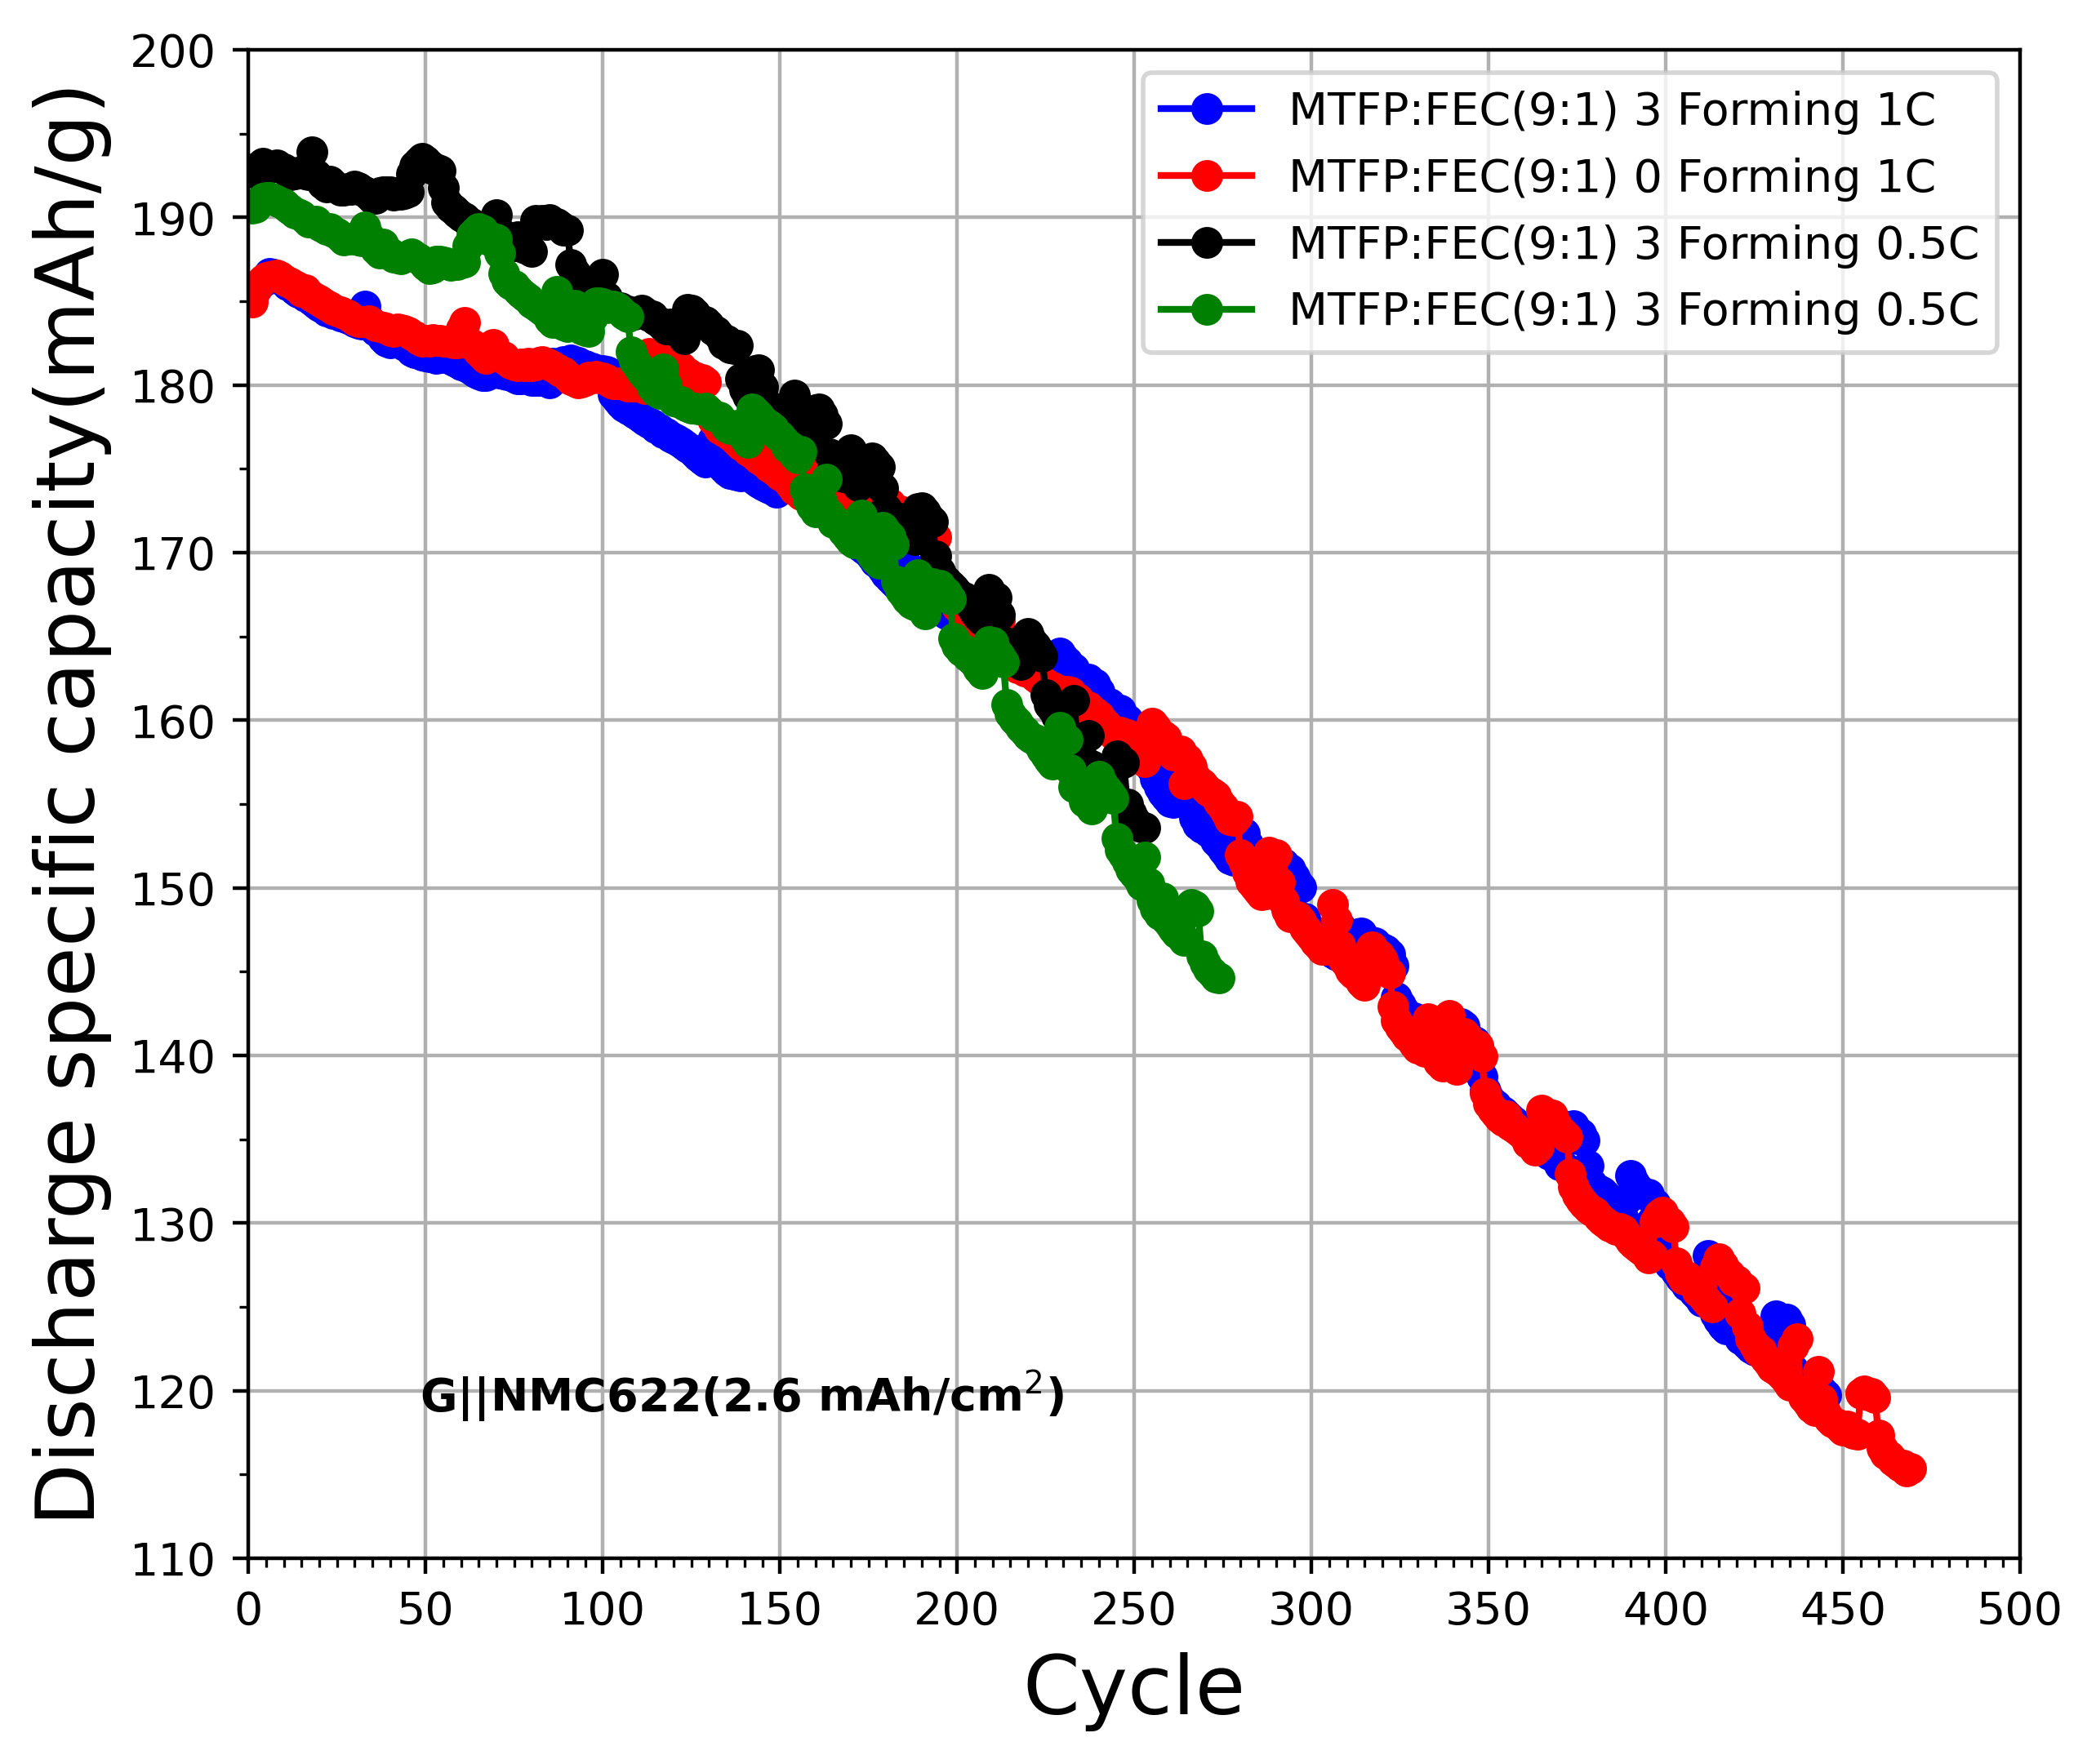

In [21]:
fig,ax = plt.subplots(figsize=(7, 6),dpi=400)
#  интервал основных делений по оси x:
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
#  интервал вспомогательных делений по оси x:
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
#  интервал основных делений по оси y:
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
#  интервал вспомогательных делений по оси y:
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
plt.xlabel("Cycle",fontsize=18)
plt.ylabel("Discharge specific capacity(mAh/g)",fontsize=18)
plt.grid(axis='y')
plt.grid(axis='x')
plt.ylim(110,200)
plt.xlim(0,500)
cell1.plot_dcap(200,110)
cell2.plot_dcap(200,110)
cell3.plot_dcap(200,110)
cell4.plot_dcap(200,110)
areal = (NMC*cell4.mass/(np.pi*(0.75**2))+NMC*cell5.mass/(np.pi*(0.75**2))+NMC*cell1.mass/(np.pi*(0.75**2)) + NMC*cell2.mass/(np.pi*(0.75**2)) + NMC*cell3.mass/(np.pi*(0.75**2)))/5
plt.text(0.2,0.185, f'G||NMC{nmc_type}'+f'({areal:.1f}' + ' mAh/cm${^2} $)',transform=fig.transFigure,weight='bold')
plt.legend(loc="upper right")
plt.savefig('cap.png')

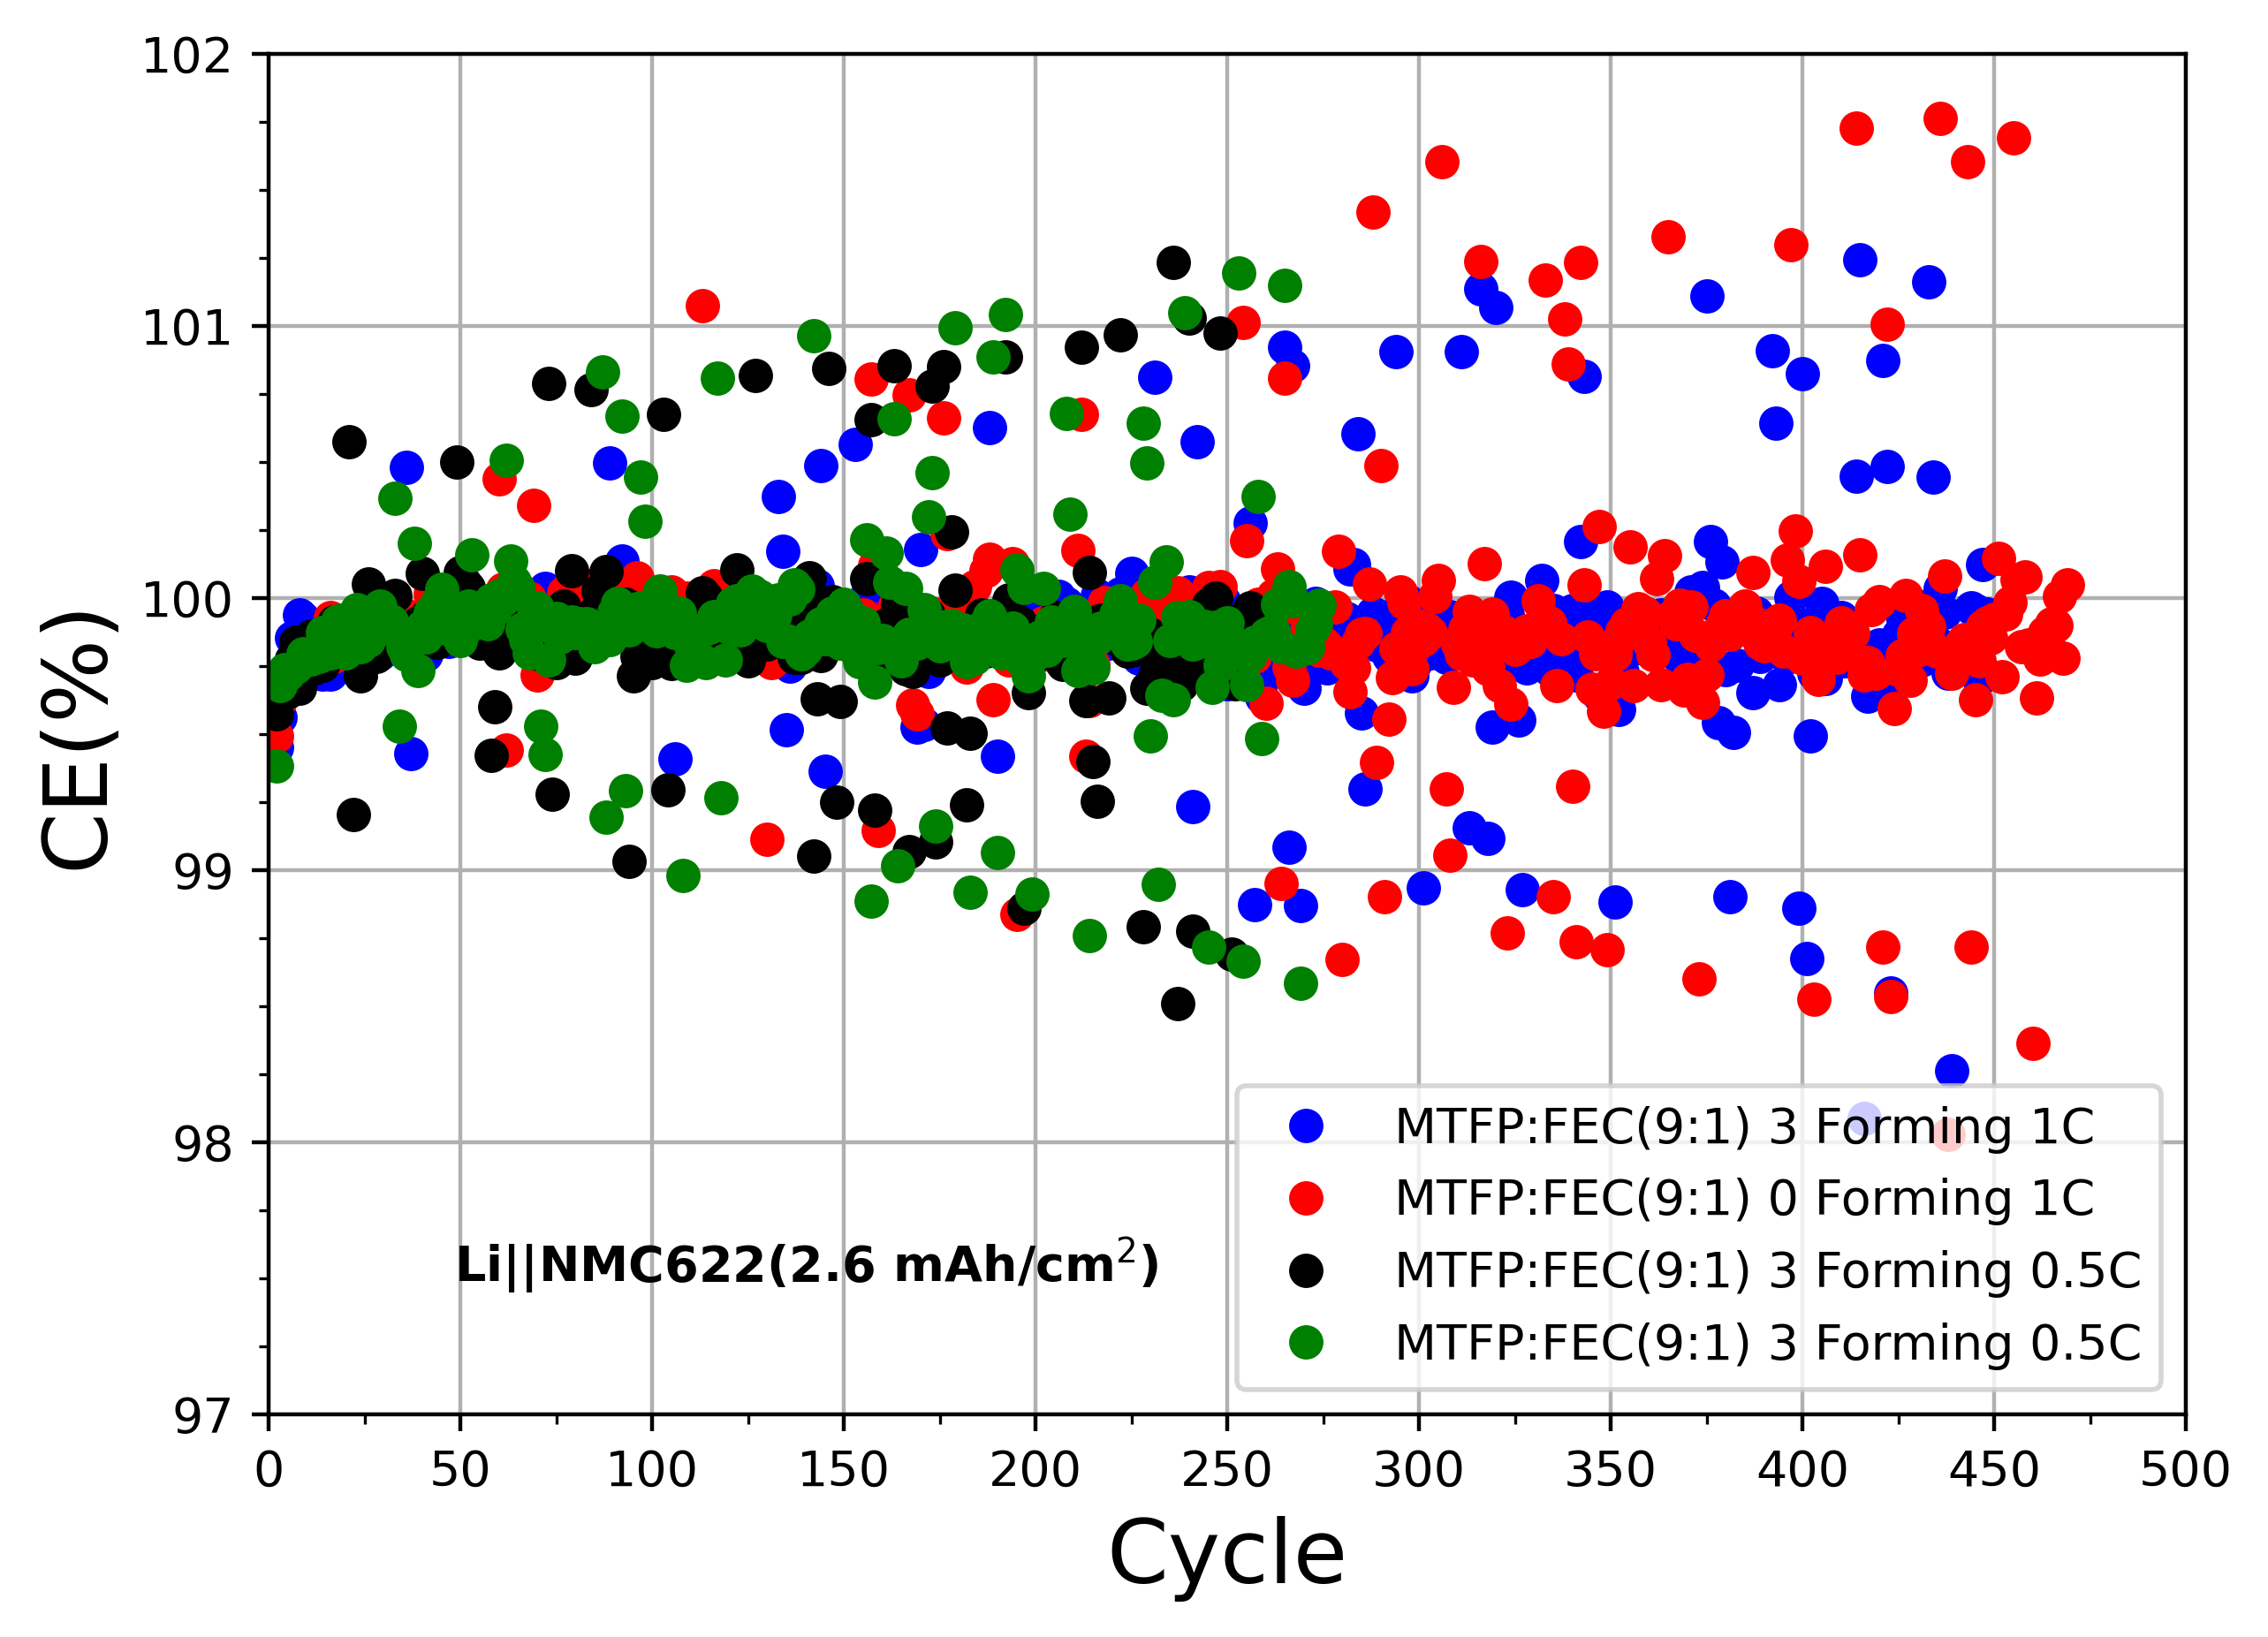

In [27]:
fig,ax = plt.subplots(figsize=(7, 5),dpi=400)
#  интервал основных делений по оси x:
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
#  интервал вспомогательных делений по оси x:
ax.xaxis.set_minor_locator(ticker.MultipleLocator(25))
#  интервал основных делений по оси y:
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#  интервал вспомогательных делений по оси y:
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
plt.xlabel("Cycle",fontsize=18)
plt.ylabel("CE(%)",fontsize=18)
plt.grid(axis='y')
plt.grid(axis='x')
plt.ylim(97,102)
plt.xlim(0,500)
cell1.plot_CE()
cell2.plot_CE()
cell3.plot_CE()
cell4.plot_CE()
plt.text(0.2,0.185, f'Li||NMC{nmc_type}'+f'({areal:.1f}' + ' mAh/cm${^2} $)',transform=fig.transFigure,weight='bold')
plt.legend(loc="lower right")
plt.savefig('CE.png')

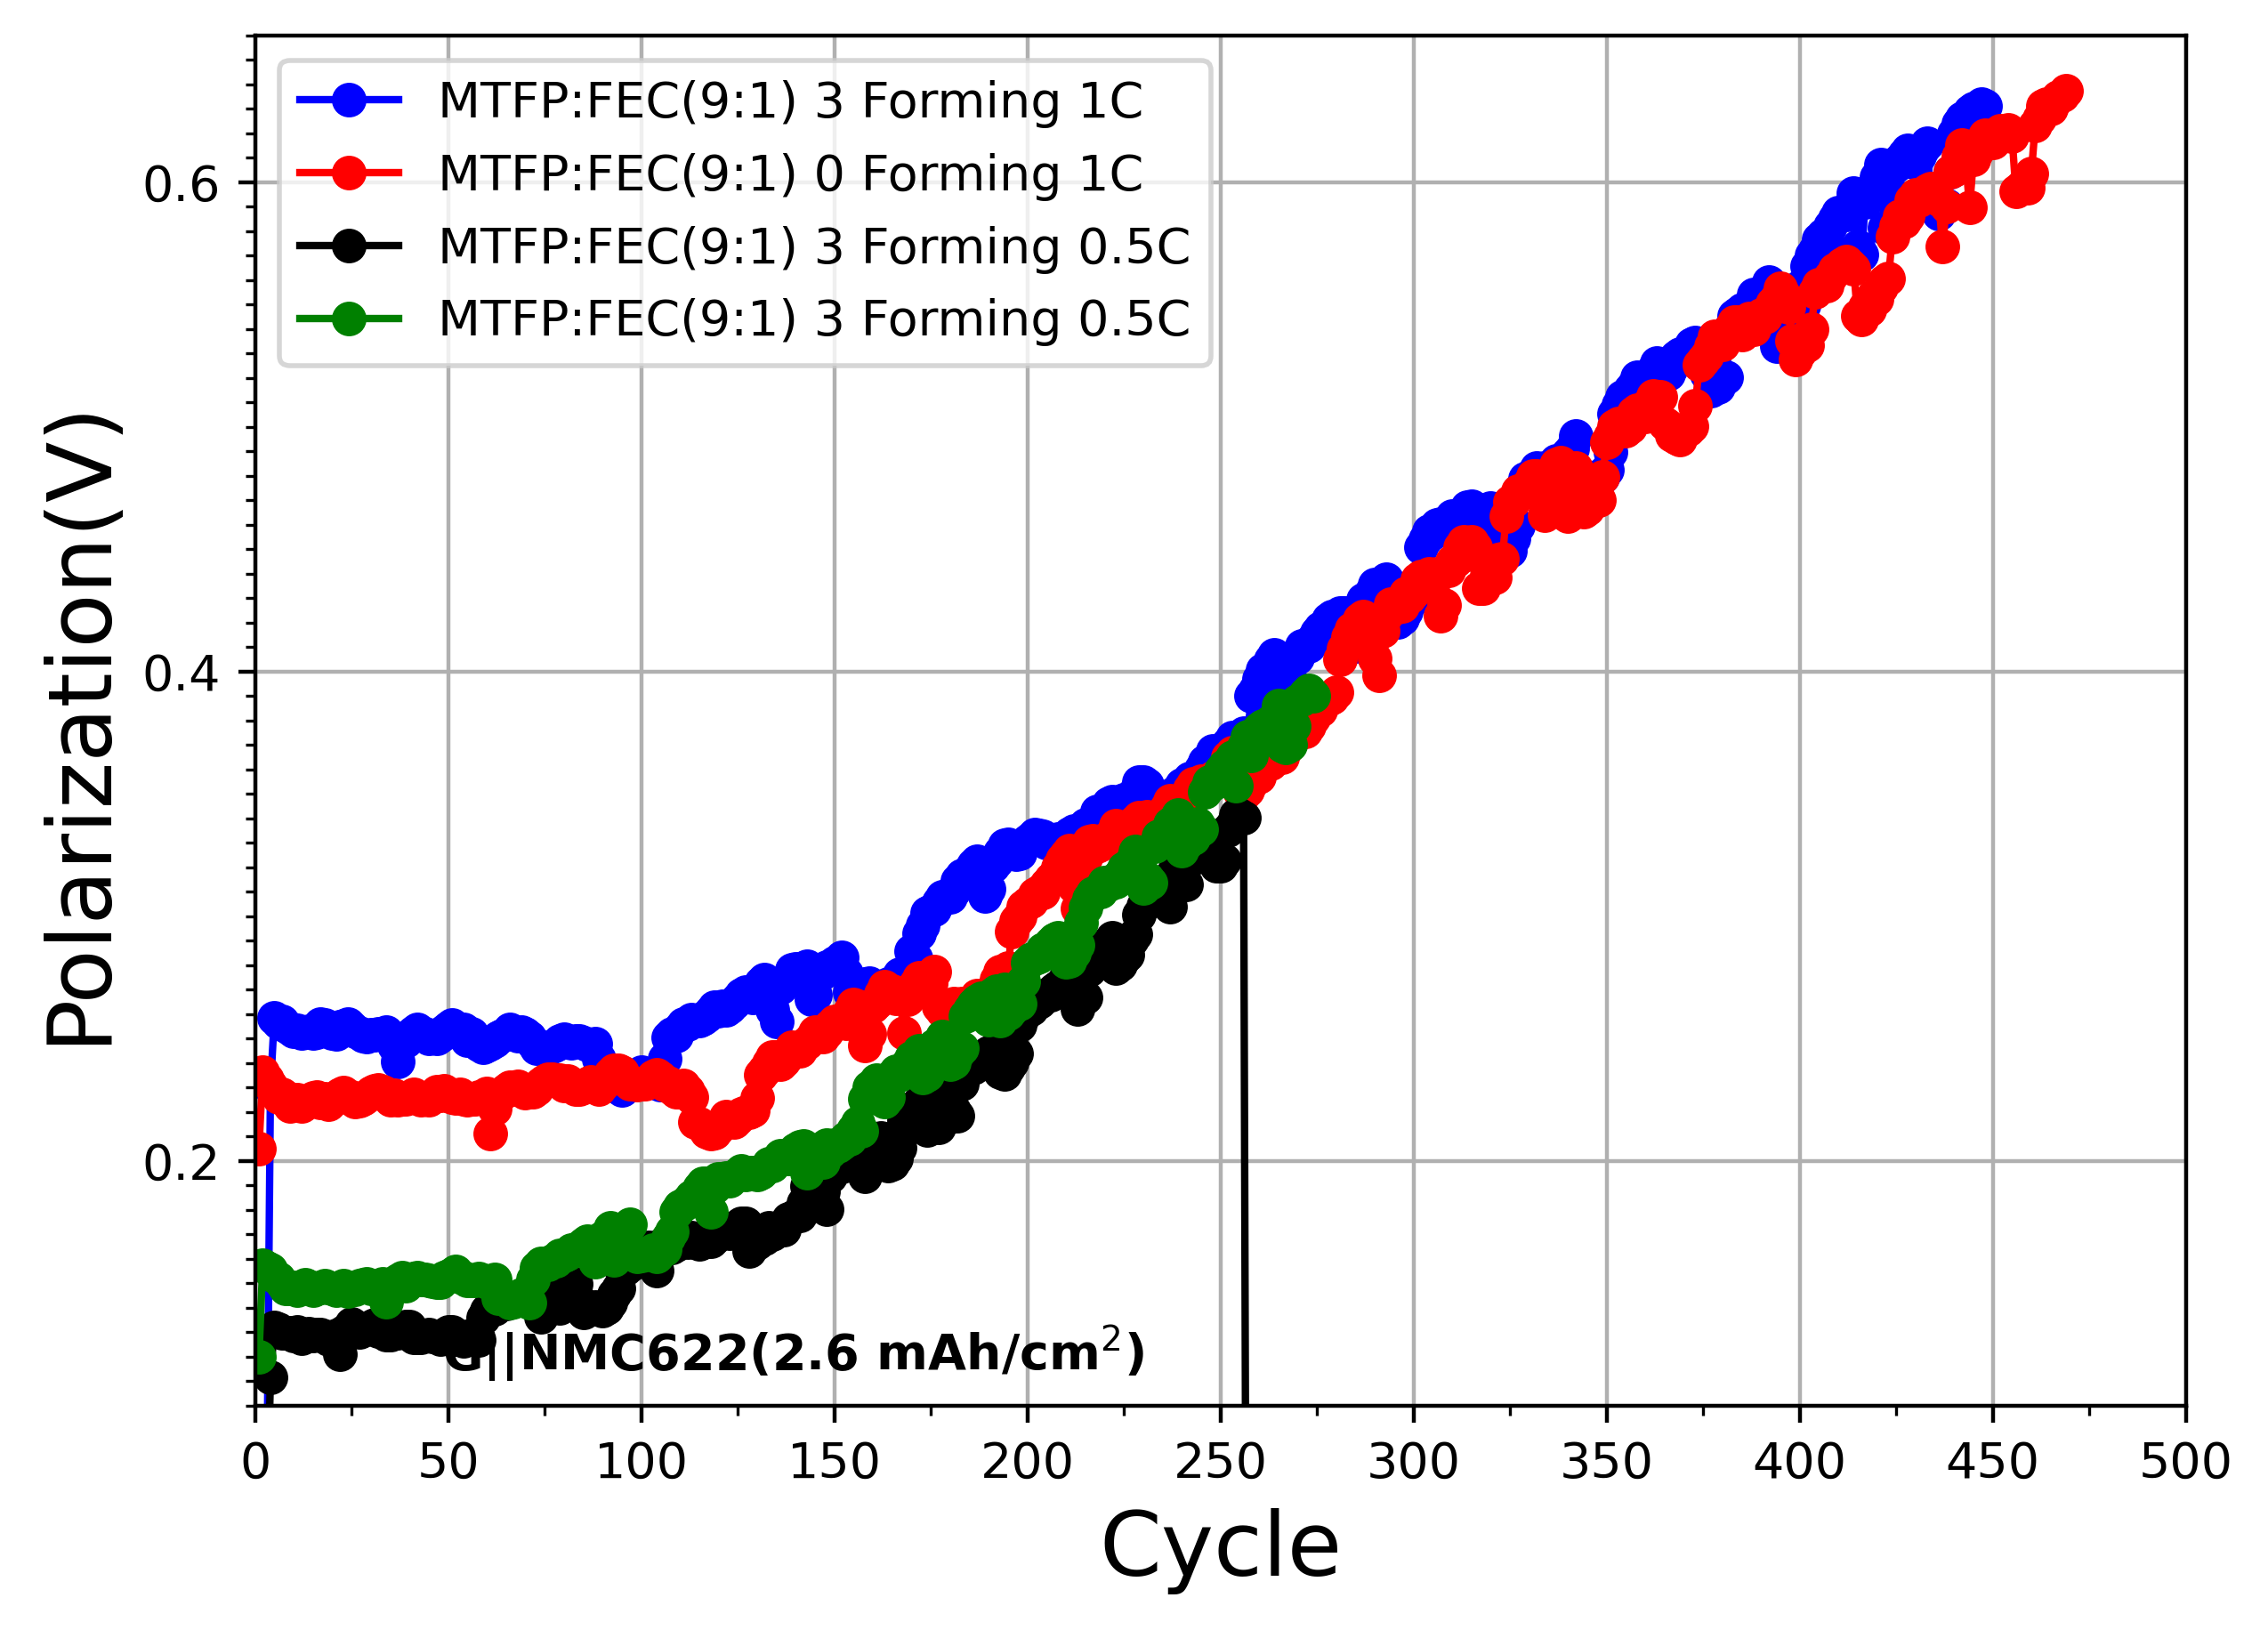

In [32]:
fig,ax = plt.subplots(figsize=(7, 5),dpi=400)
plt.xlabel("Cycle",fontsize=18)
plt.ylabel("Polarization(V)",fontsize=18)
#  интервал основных делений по оси x:
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
#  интервал вспомогательных делений по оси x:
ax.xaxis.set_minor_locator(ticker.MultipleLocator(25))
#  интервал основных делений по оси y:
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
#  интервал вспомогательных делений по оси y:
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
plt.grid(axis='y')
plt.grid(axis='x')
plt.ylim(0.10,0.66)
plt.xlim(0,500)
cell1.plot_polar()
cell2.plot_polar()
cell3.plot_polar()
cell4.plot_polar()
plt.text(0.2,0.13,f'G||NMC{nmc_type}'+f'({areal:.1f}' + ' mAh/cm${^2} $)',transform=fig.transFigure,weight='bold')
plt.legend()
plt.savefig('pol.png')